In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [59]:
base_metadata_pth = Path('/Users/tsakalis/ntua/nestor/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [60]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [61]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [62]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

In [63]:
import torch

In [64]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [65]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [66]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [67]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [201]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]
    if test_id == latent[0]:
        break
    all_latent_df.append(latent_df)

In [202]:
pd.concat([latent_df_mean, latent_df_max], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,21.318197,0.16337,0.005576,8.083027,4.269736,7.085565,3.472527,10.271541,0.587898,5.674457,...,0.019325,0.160837,23.98288,17.949211,20.918461,0.115844,14.47217,3.106407,11.481506,19.92428


In [203]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [204]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [205]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [206]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [207]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [208]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [250]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [251]:
all_data

,data_format_x,access_x,associated_entities_x,file_name_x,submitter_id_x,data_category_x,annotations_x,file_size_x,md5sum_x,file_id,...,117,34,8,114,71,62,110,27,4,20
0,SVS,open,[{'entity_submitter_id': 'TCGA-61-1903-01A-01-...,TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...,TCGA.61.1903,Biospecimen,"[{'entity_submitter_id': 'TCGA-61-1903', 'note...",200210513,05da084e2d65c34aa87bf865483f8b6d,13c2fa97-02ed-4442-aad8-9c4e6b365adc,...,8.1401,6.0462,7.6083,8.3437,7.8797,7.3016,8.3923,5.1404,7.7682,5.9685
1,SVS,open,[{'entity_submitter_id': 'TCGA-42-2587-01A-01-...,TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...,TCGA.42.2587,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2587', 'note...",138771709,c9d89dc3808a0df5bcfb7fe39994b8ca,d93b71fa-bfe0-4402-876a-b51edef5ef86,...,8.3749,5.9136,7.9143,8.6136,7.5858,7.2941,8.6792,7.6029,7.9861,8.4471
2,SVS,open,[{'entity_submitter_id': 'TCGA-29-2414-01A-02-...,TCGA-29-2414-01A-02-BS2.5006bae6-462f-4310-b8a...,TCGA.29.2414,Biospecimen,"[{'entity_submitter_id': 'TCGA-29-2414', 'note...",141220505,0ef0c1307832bc2c94ad65b2e64eedc4,9d990512-1576-4625-8fbd-a8b46fbbdf99,...,8.9513,5.9913,7.6193,10.4179,9.2474,6.6855,8.0525,6.3294,7.8052,6.5273
3,SVS,open,[{'entity_submitter_id': 'TCGA-29-2414-02A-01-...,TCGA-29-2414-02A-01-TS1.9e8b6cda-a655-40f9-a44...,TCGA.29.2414,Biospecimen,"[{'entity_submitter_id': 'TCGA-29-2414', 'note...",99784483,04cb8fd6eb96121626209cea1cf993d5,26438d97-7bd3-4f4c-9f09-38d5cef705a0,...,8.9513,5.9913,7.6193,10.4179,9.2474,6.6855,8.0525,6.3294,7.8052,6.5273
4,SVS,open,[{'entity_submitter_id': 'TCGA-24-1416-01A-01-...,TCGA-24-1416-01A-01-BS1.9af08ca1-7925-4689-9ad...,TCGA.24.1416,Biospecimen,NaN,160023955,d3d86ff3007ce6ac4adf69bd91dee64d,3170f418-ead5-48b7-9e49-6bc256f36e75,...,8.8458,5.8283,7.9525,9.1587,9.4952,6.2367,7.9672,6.572,7.4422,6.4335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,SVS,open,[{'entity_submitter_id': 'TCGA-59-2354-11A-01-...,TCGA-59-2354-11A-01-TS1.e597d6fa-9435-4056-808...,TCGA.59.2354,Biospecimen,NaN,57069143,fd35bdb7780f50c206ef986df6b7607d,b9b7fe7b-f83e-4bc6-82f0-2f81ff0c34c7,...,8.2313,5.6455,7.8046,9.5054,9.1967,5.9355,8.4785,7.3105,7.3354,7.3069
701,SVS,open,[{'entity_submitter_id': 'TCGA-24-2020-01A-01-...,TCGA-24-2020-01A-01-TS1.e210ebcd-ea37-4fe7-953...,TCGA.24.2020,Biospecimen,NaN,111180723,8d4a7486f7d66442508675dd54c65f10,ff06ad85-d1e2-49e6-975a-6d34bcf38fba,...,9.1052,5.9594,8.2652,9.2659,7.5272,7.8014,8.6894,5.513,8.6664,6.7931
702,SVS,open,[{'entity_submitter_id': 'TCGA-10-0926-01A-01-...,TCGA-10-0926-01A-01-TS1.81702be2-0c3a-4469-9a6...,TCGA.10.0926,Biospecimen,NaN,44703535,45e2b7ab823e56455299c643b2a82efa,64519ca4-6aa8-454e-b6c9-c10120fb1427,...,8.8193,6.7216,7.5514,9.3318,8.4994,6.0078,7.2716,5.7255,7.3378,5.5673
703,SVS,open,[{'entity_submitter_id': 'TCGA-13-1484-01A-01-...,TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...,TCGA.13.1484,Biospecimen,NaN,271158307,17bad5ae203854c3fa27beeaeb1d51ce,a20a6cb2-2da0-491d-a22a-3bd74fb3062e,...,9.2964,6.1838,7.3916,8.787,8.9912,6.3021,7.9721,5.7415,8.0873,7.1429


In [252]:
gene_patient.file_name


0       TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...
2       TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...
3       TCGA-29-2414-01A-02-BS2.5006bae6-462f-4310-b8a...
4       TCGA-29-2414-02A-01-TS1.9e8b6cda-a655-40f9-a44...
5       TCGA-42-2588-01A-01-TS1.cc3b36dc-1ce9-4db3-998...
                              ...                        
1364    TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...
1365    TCGA-13-0906-01A-01-BS1.e8aa0544-cc48-4941-9d7...
1366    TCGA-13-0906-01A-01-TS1.7be7e649-9db2-4a60-b12...
1367    TCGA-04-1348-01A-01-TS1.ffb07f65-72b7-494c-abf...
1368    TCGA-13-1496-01A-01-TS1.6e8bc620-4631-48ed-8bf...
Name: file_name, Length: 1337, dtype: object

In [253]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data.index,
                                       test_size=0.2,
                                       random_state=42)

In [254]:
target_labels = all_data.columns[-35:]

In [255]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [256]:
input_labels = [f"emb_{i}" for i in range(1024 * 3)]

In [257]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [259]:
# pca = PCA(n_components=700)

# pcaed = pca.fit_transform(all_data[input_labels])

# all_data_copy = all_data.copy()


In [260]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [261]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [270]:
params = {
    'n_estimators': 200,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10
}

In [271]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1, **params)  #n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.03845425249983996


In [238]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# RandomizedSearchCV for lightweight optimization
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    cv=3,  # Number of folds for cross-validation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train.values)  # Flatten y_train for regression

# Best parameters and evaluation
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
y_pred = best_model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  Fi

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
R2 Score: 0.005655491337785896
Mean Squared Error: 0.34898943420526474


In [179]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [180]:
from scipy import stats

In [241]:
corrlesb = []
for i in range(len(target_labels)):
    corrlesb.append(
        stats.spearmanr(y_test.values[:, i].flatten().astype(float),
                        y_pred[:, i].flatten()))

In [242]:
corrlesb

[SignificanceResult(statistic=np.float64(0.15000428048672013), pvalue=np.float64(0.01396659244977871)),
 SignificanceResult(statistic=np.float64(0.20187680997063726), pvalue=np.float64(0.000888303665931444)),
 SignificanceResult(statistic=np.float64(0.21003455101668028), pvalue=np.float64(0.0005381179361754259)),
 SignificanceResult(statistic=np.float64(0.11115058994431923), pvalue=np.float64(0.0692566842510015)),
 SignificanceResult(statistic=np.float64(0.10533398176118548), pvalue=np.float64(0.0852285936282103)),
 SignificanceResult(statistic=np.float64(0.08481600200166829), pvalue=np.float64(0.16620430184850526)),
 SignificanceResult(statistic=np.float64(0.27998229469509006), pvalue=np.float64(3.2315182921751107e-06)),
 SignificanceResult(statistic=np.float64(0.09329608463254578), pvalue=np.float64(0.12763156236728498)),
 SignificanceResult(statistic=np.float64(0.1142386290090178), pvalue=np.float64(0.06182569609313293)),
 SignificanceResult(statistic=np.float64(0.22033118947598007)

In [243]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])

In [244]:
# for i in range(len(target_labels)):
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train.values[:, i])

#     # Make predictions
#     y_pred = model.predict(X_test)
#     # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
#     print(r2_score(y_test.values[:, i], y_pred))
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten())[0, 1])

In [245]:
y_test.shape

(268, 35)

In [246]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

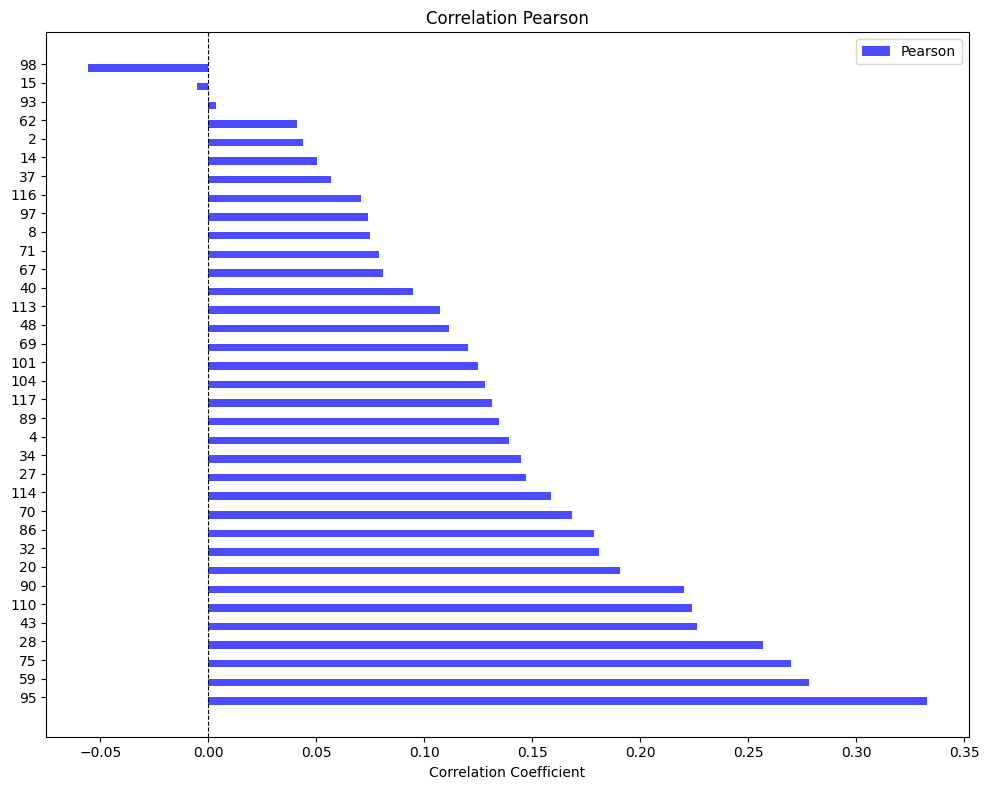

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)[::-1]
genes = np.array(target_labels)[sort_idx[:35]]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx[:35]],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, genes)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()

plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)